Sanggoroe, a platform to search and provide information related to teaching job vacancies, can help students, fresh graduates, or anyone who wants to gain teaching experience by providing information related to teaching job vacancies.

Tahapan membuat model ML :

1. [Collecting Data](#step-1) ✅
2. [Exploratory Data Analysis](#step-2) ✅
3. [Data Preprocessing](#step-3) ✅
5. [Training Model](#step-4) ✅
5. [Evaluasi Model](#step-5) ✅
6. [Deployment](#step-6) 


<a name="step-1"></a>
## **1. Data Collecting**

Proses pengumpulan data dikumpulkan secara manual melalui situs lowongan kerja untuk guru yang tersedia di Indonesia

In [84]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [85]:
from google.colab import drive, auth
from google.auth import default
import gspread as gd

In [86]:
drive.mount('/content/drive')
auth.authenticate_user()
creds,_ = default()
gc = gd.authorize(creds)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
lowongan = gc.open_by_url('https://docs.google.com/spreadsheets/d/1qHqyoNTFhKuLJ_wuSPVpT9InLXo6QiWGf9PMa8AtYiQ/edit?usp=sharing').worksheet('Lowongan Guru')

In [88]:
lowongan = lowongan.get_all_values()
data = pd.DataFrame(lowongan)
data.columns = data.iloc[0]
data = data.iloc[1:].reset_index(drop=True)

data.head()

,JobID,Jenjang,Kualifikasi,Posisi,Gender,Provinsi,Kota,Pengalaman,Skill,Gaji,Jenis,Perusahaan,TglPosting,Perusahaan,Link,Deskripsi
0,1,Kindergarten,Bachelor Degree,Kindergarten Teacher,General,Jawa Barat,Bogor,24,Proficient in English,0,Full time,PT Tunas Tuju Asa,2023-05-16,Sekolah,PRESCHOOL & KINDERGARTEN TEACHERS FOR KINDERFI...,Available for working in the new academic year...
1,2,Kindergarten,Bachelor Degree,Islamic Education Teachers,General,Banten,Tangerang,24,Proficient in English,0,Full time,PT Kinder Haven Pusaka,2023-05-18,Sekolah,Guru Agama (Religion Student Counselor) - PT K...,"Create environments, activities, and programmi..."
2,3,Kindergarten,Bachelor Degree,Kindergarten Teacher,General,DI Yogyakarta,Sleman,24,,2200000,Full time,Yayasan Pendidikan Blue Dolphin International,2023-05-18,Sekolah,Preschool and Kindergarten Teacher - Yay. Pend...,We are a well-grown English-speaking Pre-schoo...
3,4,Kindergarten,Bachelor Degree,Kindergarten Teacher,General,Jawa Timur,Surabaya,0,Proficient in English,0,Full time,Yayasan Intan Eduka,2023-05-18,Sekolah,KINDERGARTEN TEACHER - Yayasan Intan Eduka - 4...,Preparing and delivering lessons to a range of...
4,5,Elementary School,Diploma Degree,Natural Sciences Teacher,General,Jawa Barat,Depok,0,Proficient in English,2000000,Full time,Pratiwi School Depok,2023-05-17,Sekolah,Science and Mathematics Teachers - Pratiwi Sch...,"Age max 35 years old, Bachelor degree in Educa..."


<a name="step-2"></a>
## **2. Exploratory Data Analysis**

Exploratory data analysis atau EDA bertujuan sebagai analisa awal terhadap data dan melihat bagaimana kualitas data untuk meminimalkan potensi kesalahan di kemudian hari. Pada proses ini dilakukan investigasi awal pada data untuk menemukan pola, anomali, menguji hipotesis , memahami distribusi, frekuensi, hubungan antar variabel, dan memeriksa asumsi dengan teknik statistik dan representasi grafik. <br>
Source: Dicoding

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [90]:
data.columns

Index(['JobID', 'Jenjang', 'Kualifikasi', 'Posisi', 'Gender', 'Provinsi',
       'Kota', 'Pengalaman', 'Skill', 'Gaji', 'Jenis', 'Perusahaan',
       'TglPosting', 'Perusahaan', 'Link', 'Deskripsi'],
      dtype='object', name=0)

In [91]:
# Melihat informasi dasar tentang dataset
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   JobID        172 non-null    object
 1   Jenjang      172 non-null    object
 2   Kualifikasi  172 non-null    object
 3   Posisi       172 non-null    object
 4   Gender       172 non-null    object
 5   Provinsi     172 non-null    object
 6   Kota         172 non-null    object
 7   Pengalaman   172 non-null    object
 8   Skill        172 non-null    object
 9   Gaji         172 non-null    object
 10  Jenis        172 non-null    object
 11  Perusahaan   172 non-null    object
 12  TglPosting   172 non-null    object
 13  Perusahaan   172 non-null    object
 14  Link         172 non-null    object
 15  Deskripsi    172 non-null    object
dtypes: object(16)
memory usage: 21.6+ KB
None


In [92]:
# lowongan.isnull().sum()

In [93]:
# Melihat statistik deskriptif dasar
data.describe()

,JobID,Jenjang,Kualifikasi,Posisi,Gender,Provinsi,Kota,Pengalaman,Skill,Gaji,Jenis,Perusahaan,TglPosting,Perusahaan,Link,Deskripsi
count,172,172,172,172,172,172,172,172,172,172,172,172,172,172,172,172
unique,172,6,4,68,3,15,28,5,31,4,5,33,20,3,33,36
top,1,General,Bachelor Degree,Kindergarten Teacher,General,Jawa Barat,Surabaya,0,Proficient in English,0,Full time,Sekolah Citra Kasih - Sekolah Ciputra Kasih - ...,2023-05-04,Sekolah,https://citrakasih.sch.id/vacancy/,"Maximum age of 35 years old, Bachelor's degree..."
freq,1,70,127,12,150,46,18,108,58,167,129,91,91,151,91,53


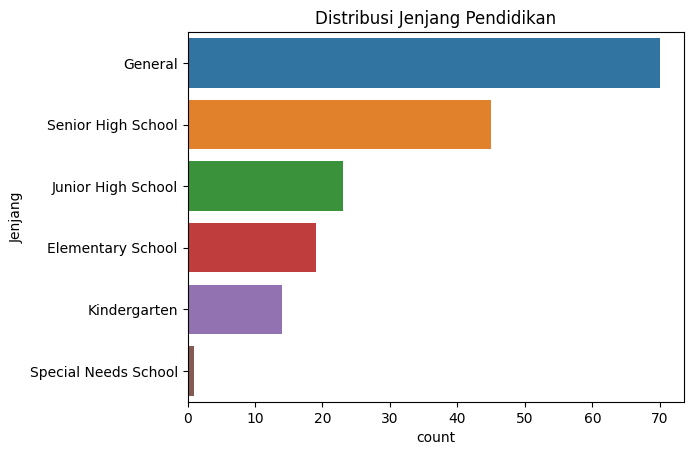

In [94]:
sns.countplot(y='Jenjang', data=data, order = data['Jenjang'].value_counts().index)
plt.title('Distribusi Jenjang Pendidikan')
plt.show()

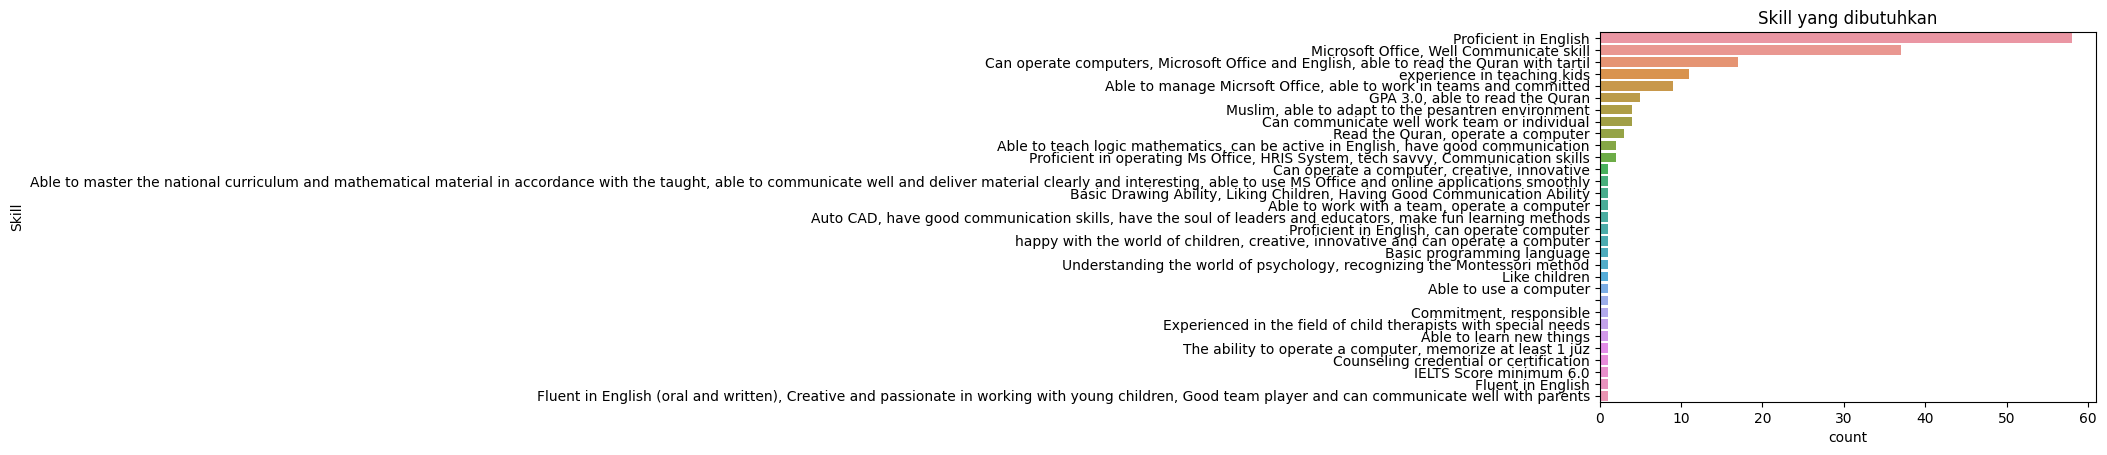

In [95]:
sns.countplot(y='Skill', data=data, order = data['Skill'].value_counts().index)
plt.title('Skill yang dibutuhkan')
plt.show()

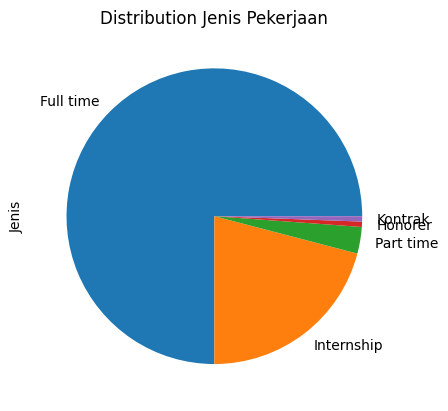

In [96]:
# Plot pie chart untuk 'Jenis Pekerjaan'
data['Jenis'].value_counts().plot(kind='pie')
plt.title('Distribution Jenis Pekerjaan')
plt.show()

In [97]:
data['Posisi'].value_counts()

Kindergarten Teacher      12
It teacher                11
English teacher           10
Digital Marketing          9
Indonesian Teacher         7
                          ..
Music teacher              1
General Affair             1
Physics Teacher            1
Art and Music Teacher      1
Graphic design teacher     1
Name: Posisi, Length: 68, dtype: int64

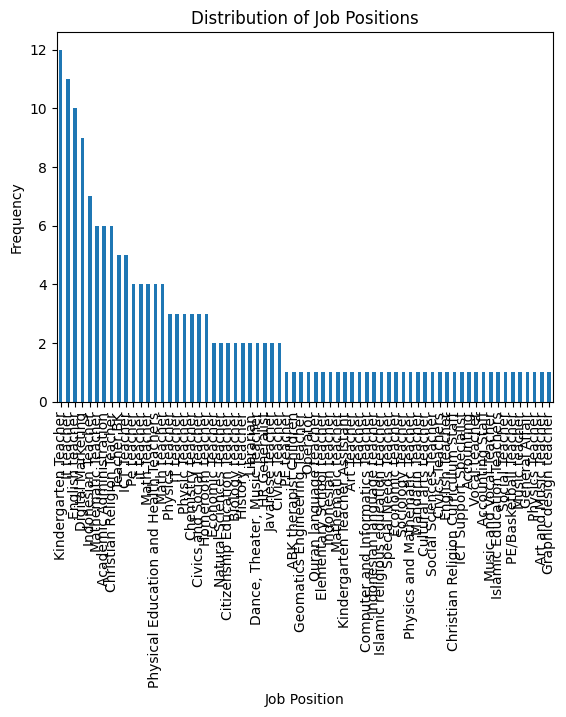

In [98]:
data['Posisi'].value_counts().plot(kind='bar')
plt.title('Distribution of Job Positions')
plt.xlabel('Job Position')
plt.ylabel('Frequency')
plt.show()

In [99]:
print(data.groupby('Jenis')['Posisi'].value_counts())

Jenis      Posisi              
Full time  It teacher              9
           Kindergarten Teacher    8
           Indonesian Teacher      6
           Mathematic Teacher      6
           Digital Marketing       5
                                  ..
Kontrak    Kindergarten Teacher    1
Part time  It teacher              2
           English Teacher         1
           English teacher         1
           Indonesian Teacher      1
Name: Posisi, Length: 83, dtype: int64


In [100]:
print(data.groupby('Jenjang')['Posisi'].value_counts())

Jenjang               Posisi                   
Elementary School     Homeroom teacher             2
                      Mathematic Teacher           2
                      Art and Music Teacher        1
                      Elementary School teacher    1
                      English Teacher              1
                                                  ..
Senior High School    PE/Basketball Teacher        1
                      Pe teacher                   1
                      Physics Teacher              1
                      Sociology Teacher            1
Special Needs School  Special Needs Teacher        1
Name: Posisi, Length: 99, dtype: int64


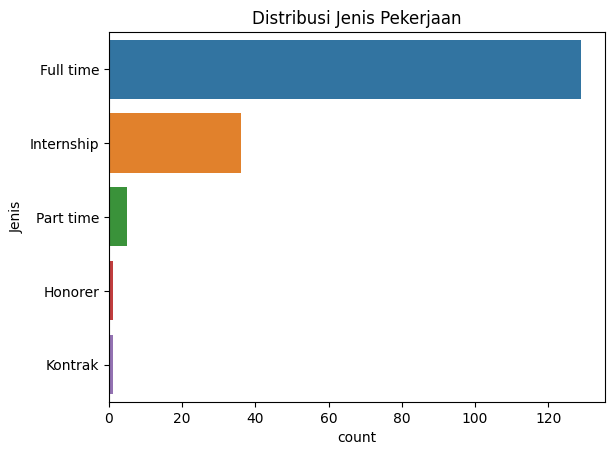

In [101]:
# Melihat distribusi Jenis Pekerjaan
sns.countplot(y='Jenis', data=data, order = data['Jenis'].value_counts().index)
plt.title('Distribusi Jenis Pekerjaan')
plt.show()

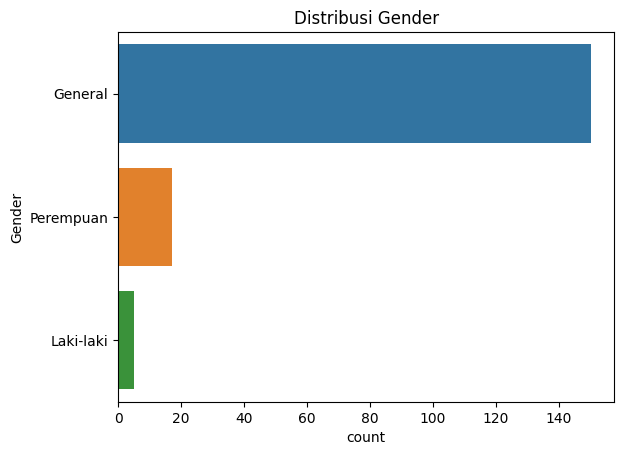

In [102]:
# Melihat distribusi Gender
sns.countplot(y='Gender', data=data, order = data['Gender'].value_counts().index)
plt.title('Distribusi Gender')
plt.show()

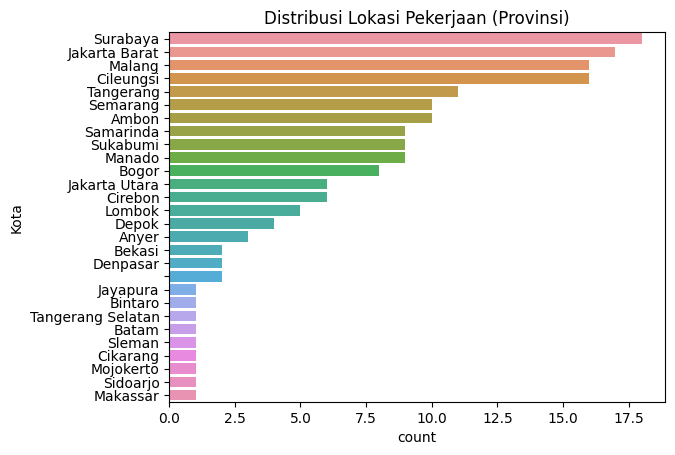

In [103]:
# Melihat distribusi Lokasi Pekerjaan
sns.countplot(y='Kota', data=data, order = data['Kota'].value_counts().index)
plt.title('Distribusi Lokasi Pekerjaan (Provinsi)')
plt.show()


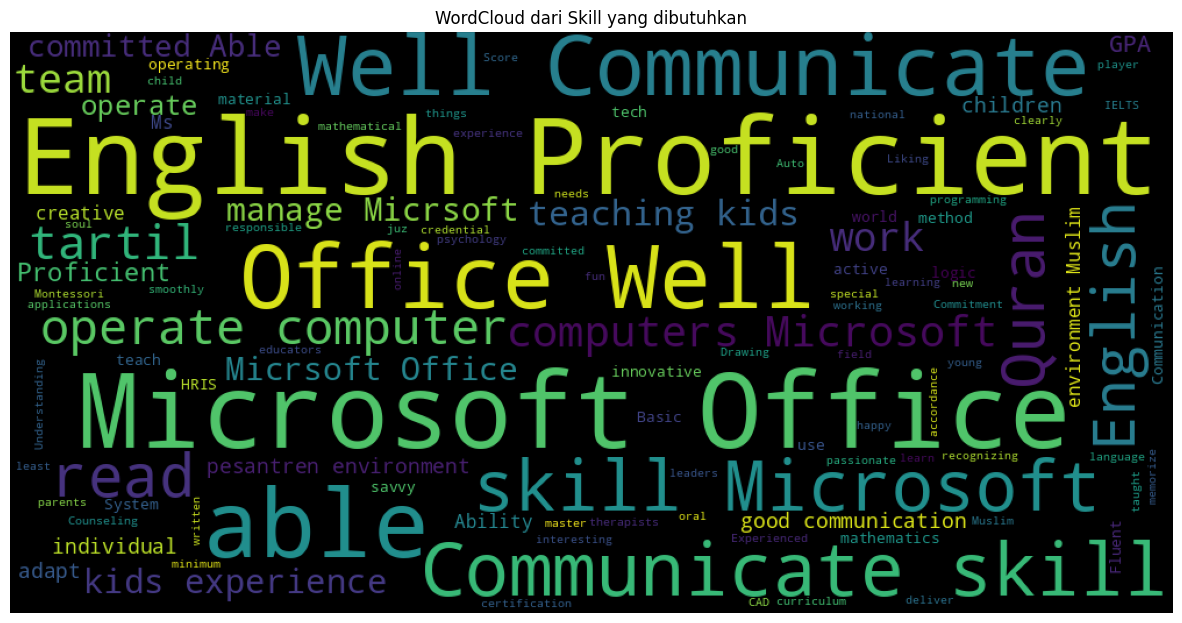

In [104]:
# Membuat WordCloud dari Skill yang dibutuhkan
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(data['Skill']))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('WordCloud dari Skill yang dibutuhkan')
plt.show()


In [105]:
# Membuat scatterplot Pengalaman Kerja (bulan) vs Gaji
# sns.scatterplot(x='Pengalaman', y='Gaji', data=data)
# plt.title('Scatterplot Pengalaman Kerja (bulan) vs Gaji')
# plt.show()

# Hitung korelasi antara fitur numerik
# corr = data[['Pengalaman', 'Gaji']].corr()

# Buat heatmap dari korelasi
# sns.heatmap(corr, annot=True, cmap='coolwarm')
# plt.title('Heatmap Korelasi Fitur Numerik')
# plt.show()

<a name="step-3"></a>
## **3. Data Preprocessing**
Data preprocessing adalah tahap di mana data diolah lebih lanjut sehingga menjadi siap dipakai dalam pengembangan model ML. Dengan kata lain, proses ini mengubah dan mentransformasi fitur-fitur data ke dalam bentuk yang mudah diinterpretasikan dan diproses oleh algoritma machine learning. Termasuk di dalam data preprocessing adalah proses data cleaning dan data transformation.<br>
Source: Dicoding


In [106]:
#subsetting only needed columns and not considering the columns that are not necessary
cols = list(['JobID']+['Posisi']+ ['Skill'] )
final_lowongan =data[cols]
final_lowongan.columns = ['Job.ID','Position','Skill']
final_lowongan.head() 

# Menggunakan heatmap

,Job.ID,Position,Skill
0,1,Kindergarten Teacher,Proficient in English
1,2,Islamic Education Teachers,Proficient in English
2,3,Kindergarten Teacher,
3,4,Kindergarten Teacher,Proficient in English
4,5,Natural Sciences Teacher,Proficient in English


In [107]:
# final_lowongan['Skill'].fillna('Good Communication', inplace=True)
final_lowongan['Skill'].replace('', 'Good Communication', inplace=True)

<ipython-input-107-398f268324f0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_lowongan['Skill'].replace('', 'Good Communication', inplace=True)


In [108]:
final_lowongan.head()

,Job.ID,Position,Skill
0,1,Kindergarten Teacher,Proficient in English
1,2,Islamic Education Teachers,Proficient in English
2,3,Kindergarten Teacher,Good Communication
3,4,Kindergarten Teacher,Proficient in English
4,5,Natural Sciences Teacher,Proficient in English


In [109]:
final_lowongan["pos_skill"] = final_lowongan["Position"].map(str) +" "+ final_lowongan["Skill"] 
final_lowongan.pos_skill.values
# final_lowongan.pos_skill.values

<ipython-input-109-6e5602695e1f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_lowongan["pos_skill"] = final_lowongan["Position"].map(str) +" "+ final_lowongan["Skill"]


array(['Kindergarten Teacher Proficient in English',
       'Islamic Education Teachers Proficient in English',
       'Kindergarten Teacher Good Communication',
       'Kindergarten Teacher Proficient in English',
       'Natural Sciences Teacher Proficient in English',
       'Math teacher Proficient in English',
       'Physical Education and Health Teachers Microsoft Office, Well Communicate skill',
       'Cultural arts teacher Read the Quran, operate a computer',
       'Social Sciences Teacher Read the Quran, operate a computer',
       'Civics Teachers Read the Quran, operate a computer',
       'It teacher experience in teaching kids',
       'It teacher experience in teaching kids',
       'It teacher experience in teaching kids',
       'It teacher experience in teaching kids',
       'It teacher experience in teaching kids',
       'It teacher experience in teaching kids',
       'It teacher experience in teaching kids',
       'It teacher experience in teaching kids',
    

In [110]:
# Mengubah semua teks ke huruf kecil

In [111]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [112]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

# Create an object of class PorterStemmer
porter = PorterStemmer()

# Define the stop words
stop_words = set(stopwords.words('english')) 

# Function to preprocess the data
def preprocess_data(data):
    # Lowercasing the data
    data = data.lower()
    # Removing the punctuations
    data = re.sub(r'[^\w\s]', '', data)
    # Stemming the data
    data = porter.stem(data)
    # Removing the stop words
    data = " ".join(word for word in data.split() if word not in stop_words)
    return data

# Preprocessing the job descriptions
final_lowongan["pos_skill"] = final_lowongan["pos_skill"].apply(preprocess_data)

<ipython-input-112-2aa01c357e7a>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_lowongan["pos_skill"] = final_lowongan["pos_skill"].apply(preprocess_data)


In [113]:
# final_lowongan['pos_skill'].replace('', np.nan, inplace=True)
# final_lowongan['pos_skill'].isnull().sum()
# final_lowongan.dropna(subset=['pos_skill'],inplace=True)
final_lowongan["pos_skill"]

0                kindergarten teacher proficient english
1          islamic education teachers proficient english
2                       kindergarten teacher good commun
3                kindergarten teacher proficient english
4            natural sciences teacher proficient english
                             ...                        
167    physics teacher able manage micrsoft office ab...
168    academic administration able manage micrsoft o...
169    teacher able manage micrsoft office able work ...
170    indonesian teacher able manage micrsoft office...
171    kindergarten teacher fluent english oral writt...
Name: pos_skill, Length: 172, dtype: object

In [114]:
data2 = list(final_lowongan["pos_skill"].values)

In [115]:
# Membuat list_of_descriptions
list_of_descriptions = [desc.split() for desc in data2]

In [116]:
from tensorflow.keras.layers import Dropout
# Membuat dan menyimpan model Word2Vec
model = Word2Vec(list_of_descriptions, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

# Fungsi untuk mendapatkan vektor
def get_vector(word_list):
    vector_sum = sum(model.wv[word] for word in word_list if word in model.wv)
    return vector_sum / len(word_list)

# Membuat vektor pekerjaan
job_vectors = np.array([get_vector(desc) for desc in list_of_descriptions])
job_vectors = np.reshape(job_vectors, (len(job_vectors), -1))  # reshape job vectors to 2D

<a name="step-4"></a>
## **4. Training Model**


In [117]:
# Membuat dan melatih model rekomendasi
rec_model = Sequential()
rec_model.add(Dense(128, activation='relu', input_dim=100))
rec_model.add(Dense(64, activation='relu'))
rec_model.add(Dense(len(job_vectors[0]), activation='linear'))  # Output layer

rec_model.compile(loss='mse', optimizer='adam', metrics=['mae'])

# Melatih model dan menyimpan history
history = rec_model.fit(job_vectors, job_vectors, epochs=50, verbose=1)

Epoch 1/50
6/6 [==============================] - 1s 5ms/step - loss: 6.9332e-06 - mae: 0.0021
Epoch 2/50
6/6 [==============================] - 0s 4ms/step - loss: 5.3091e-06 - mae: 0.0018
Epoch 3/50
6/6 [==============================] - 0s 4ms/step - loss: 4.8257e-06 - mae: 0.0017
Epoch 4/50
6/6 [==============================] - 0s 4ms/step - loss: 4.7105e-06 - mae: 0.0017
Epoch 5/50
6/6 [==============================] - 0s 4ms/step - loss: 4.5860e-06 - mae: 0.0017
Epoch 6/50
6/6 [==============================] - 0s 4ms/step - loss: 4.5266e-06 - mae: 0.0017
Epoch 7/50
6/6 [==============================] - 0s 5ms/step - loss: 4.4840e-06 - mae: 0.0017
Epoch 8/50
6/6 [==============================] - 0s 6ms/step - loss: 4.4577e-06 - mae: 0.0017
Epoch 9/50
6/6 [==============================] - 0s 5ms/step - loss: 4.4369e-06 - mae: 0.0017
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 4.4691e-06 - mae: 0.0017
Epoch 11/50
6/6 [==============================] 

<a name="step-5"></a>
## **5. Evaluasi Model**

In [118]:
loss, mae = rec_model.evaluate(job_vectors, job_vectors)
print('Loss:', loss)
print('MAE:', mae)

6/6 [==============================] - 0s 4ms/step - loss: 3.4853e-06 - mae: 0.0015
Loss: 3.485275101411389e-06
MAE: 0.001463285181671381


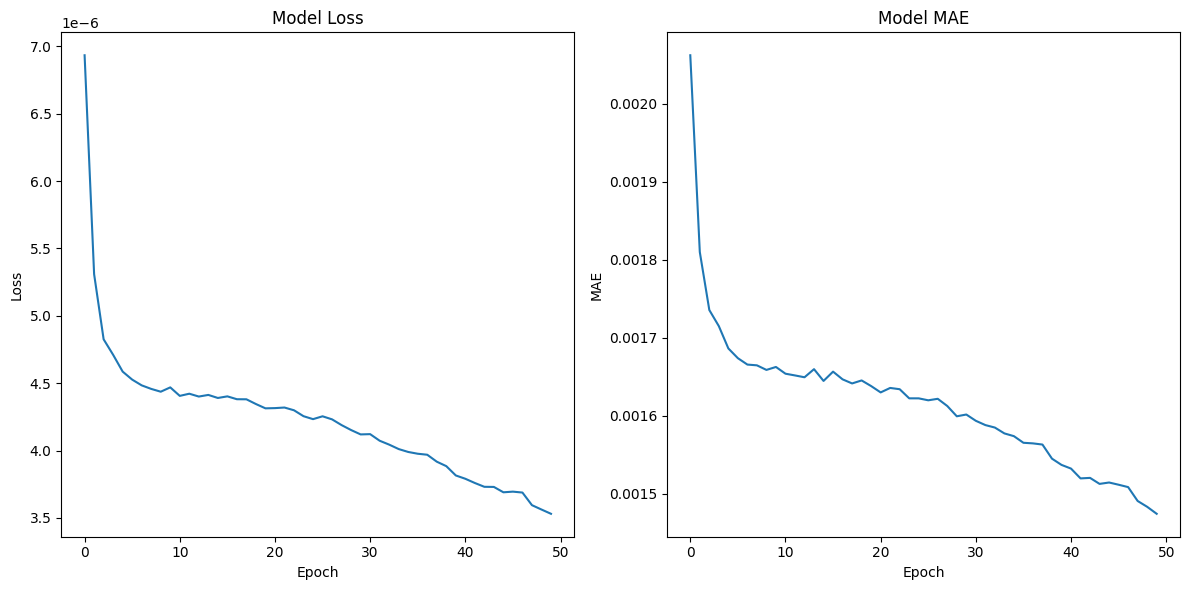

In [119]:
import matplotlib.pyplot as plt

# Membuat figure
plt.figure(figsize=(12, 6))

# Membuat plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

# Membuat plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')

# Menampilkan plot
plt.tight_layout()
plt.show()


In [120]:
# Fungsi untuk mendapatkan pekerjaan yang mirip
def get_similar_jobs(vector):
    similarities = cosine_similarity([vector], job_vectors)[0]
    indices = np.argsort(similarities)[-3:]  # Mengambil 3 pekerjaan dengan kesamaan tertinggi
    return [data2[i] for i in indices]

# Fungsi untuk memberikan rekomendasi
def recommend_jobs(user_description):
    user_vector = get_vector(user_description.split())
    user_vector = np.reshape(user_vector, (1, -1))  # reshape user vector to 2D
    predicted_vector = rec_model.predict(user_vector)[0]
    recommended_jobs = get_similar_jobs(predicted_vector)
    return recommended_jobs

# Mencoba sistem rekomendasi
print(recommend_jobs("I have experience in computer"))

1/1 [==============================] - 0s 63ms/step
['english teacher microsoft office well communicate skil', 'english teacher microsoft office well communicate skil', 'english teacher microsoft office well communicate skil']


In [121]:
import pandas as pd

# Fungsi untuk mendapatkan pekerjaan yang mirip
def get_similar_jobs(vector):
    similarities = cosine_similarity([vector], job_vectors)[0]
    df = pd.DataFrame(data={
        'JobID' : final_lowongan["Job.ID"],
        'Position' : final_lowongan["Position"],
        'Job': data2,
        'Similarity': similarities
    })
    df = df.sort_values(by='Similarity', ascending=False)  # Urutkan berdasarkan Similarity
    return df

# Fungsi untuk memberikan rekomendasi
def recommend_jobs(user_description):
    user_vector = get_vector(user_description.split())
    user_vector = np.reshape(user_vector, (1, -1))  # reshape user vector to 2D
    predicted_vector = rec_model.predict(user_vector)[0]
    recommended_jobs = get_similar_jobs(predicted_vector)
    return recommended_jobs

# Mencoba sistem rekomendasi
recommend_jobs("I have experience in english").head(10)


1/1 [==============================] - 0s 31ms/step


,JobID,Position,Job,Similarity
107,108,IT teacher,teacher proficient english,0.874496
110,111,Mathematic Teacher,mathematic teacher proficient english,0.849300
87,88,English teacher,english teacher proficient english,0.843957
75,76,English teacher,english teacher proficient english,0.843957
32,33,English teacher,english teacher proficient english,0.843957
97,98,Physics Teacher,physics teacher proficient english,0.840087
78,79,History teacher,history teacher proficient english,0.837753
26,27,Economic Teacher,economic teacher proficient english,0.820966
28,29,Economic Teacher,economic teacher proficient english,0.820966
73,74,Homeroom teacher,homeroom teacher proficient english,0.818943


In [122]:
rec_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               12928     
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 100)               6500      
                                                                 
Total params: 27,684
Trainable params: 27,684
Non-trainable params: 0
_________________________________________________________________


In [123]:
rec_model.save('rec_model.h5')

In [126]:
final_lowongan.to_csv('jobs.csv')

In [124]:
# rec_model.save('model')